# Reto técnico Data Scientist [DD360]
## Reto de precios

Autor: Daniel A. Armas. <daniel.armas.texta@gmail.com>

## Introducción

El objetivo de este reto es poder determinar cuales son las principales variables que afectan el precio por metro cuadrado de las propiedades en venta.

Primero realizaremos una limpieza de los datos, para posteriormente hacer _feature engineering_ e imputación de nulos. 

El valor agregado en este reto se encuentra en el uso de técnicas de analítica de texto para la creación de variables auxiliares. Usando el texto contenido en las _location_ y _description_ se construirán los correspondientes vocabularios y así crear variables adicionales de acuerdo a la descripción del anuncio para cada propiedad.

Una vez realizado lo anterior, se ajustarán diferentes modelos de regresión a los datos limpios y posteriormente poder determinar las variables más relevantes asociadas al precio por metro cuadrado de la propiedad (usando la importancia de las variables en el modelo).

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
import nltk, itertools, string, unicodedata, re
from scipy.spatial import distance_matrix
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn import tree,neighbors

In [2]:
sw=stopwords.words("spanish")

## Funciones

Se generan las funciones que se ocuparán a lo largo del reto

In [3]:
#función para eliminar caracteres especiales y números del texto
def r_ce(text):
    sn=re.sub("[0-9]+", "", text) 
    ce={"?","¿","¡","!",",",".",";",":","-","'","´","\n","*","[","]",
       "(",")","{","}", "/","_","·","•","$","=","+","\t","%","@", '"',"°"}
    return "".join(c for c in sn.lower() if c not in ce)

#función para eliminar acentos del texto
def r_ac(text):
    sin_ac=unicodedata.normalize("NFKD",text)
    return u"".join([c for c in sin_ac if not unicodedata.combining(c)])

#función para eliminar stopwords del texto
def r_sw(text,sw):
    return " ".join(c for c in text.split() if c not in sw)

#función para eliminar la última 's' de cada palabra
def quita_s(texto):
    palabras=[]
    for x in texto.split():
        if len(x)>2 and x[-1]=="s":
            x_new="".join(i for i in x[:-1])
        else:
            x_new=x
        palabras.append(x_new)
    return " ".join(i for i in palabras)

In [4]:
##función para ajustar diferentes modelos de regresión al conjunto de datos
def regression_model(X,y,splits=10,preprocess=True):
    random_state=42
    #Creamos el K-Fold#
    kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
    #Variables de nombres#
    model=["DTree", "KNN", "XGBoost"]
    metricas=['MSE', 'RMSE','MAE', 'R2',"Modelo"]
    n_neighbors = 7
    i=0
    #Iteramos para cada modelo#
    for modelo in model: 
        MSE = []
        RMSE = []
        MAE = []
        R2 = []

        for tr, ts in kf.split(X):
            if preprocess==True:

                if modelo=="DTree":
                    mdl = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=n_neighbors,random_state=random_state)).fit(X[tr], y[tr])
                elif modelo=="KNN":
                    mdl = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=n_neighbors)).fit(X[tr], y[tr])
                else:
                    mdl = make_pipeline(StandardScaler(),xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                                                      max_depth = n_neighbors+3, alpha = 10, n_estimators = 25)).fit(X[tr], y[tr])
            else:
                
                if modelo=="DTree":
                    mdl = DecisionTreeRegressor(max_depth=n_neighbors,random_state=random_state).fit(X[tr], y[tr])
                elif modelo=="KNN":
                    mdl = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X[tr], y[tr])
                else:
                    mdl = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                                                      max_depth = n_neighbors+3, alpha = 10, n_estimators = 25).fit(X[tr], y[tr])
                                           
            
            y_pred=mdl.predict(X[ts])
            MSE.append(mean_squared_error(y[ts], y_pred))
            RMSE.append(np.sqrt(mean_squared_error(y[ts], y_pred)))
            MAE.append(mean_absolute_error(y_pred,y[ts]))
            R2.append(r2_score(y[ts],y_pred))

        print(modelo+"... Finished!")

        _=np.transpose([MSE, RMSE, MAE, R2, np.repeat(modelo, len(R2))])
        
        #Guardamos la salida de cada modelo en diferentes DataFrames#
        if i==0:
            salida0=pd.DataFrame(_, columns=metricas)
        elif i==1:
            salida1=pd.DataFrame(_, columns=metricas)
        elif i==2:
            salida2=pd.DataFrame(_, columns=metricas)
        else:
            salida3=pd.DataFrame(_, columns=metricas)
        i+=1
        #break
        
    #Generamos salida final uniendo todos los DataFrames#
    _ = pd.concat([salida0,salida1, salida2], ignore_index=True)
    #_ = pd.concat([salida0], ignore_index=True)
    convert_dict = {'MSE': float, 
                    'RMSE': float,
                    'MAE': float,
                    'R2': float
                   }   
    datos = _.astype(convert_dict) 
    return datos

In [5]:
#función para ajustar modelos
def models(data,to_drop,y,model_type='regression',preproc=False,binary=True):
    data_mdl1=data.drop(to_drop,axis=1)
    Y=data_mdl1[y].to_numpy()
    aux=set(data_mdl1.columns)
    aux.remove(y)
    features=sorted(list(aux))
    X=data_mdl1[features].to_numpy()
    
    if model_type=="regression":
        resultados=regression_model(X,Y,preprocess=preproc)
        models=["DTree", "KNN", "XGBoost"]
        metricas=['MSE', 'RMSE','MAE', 'R2']
    else:
        resultados=classification_model(X,Y,preprocess=preproc,binary=binary)
        models=["Logit","SVM", "D-Tree", "KNN"]
        metricas=['F1score', 'Accuracy','Recall', 'Precision']
    #Generamos un resumen

    resumen={}

    for metrica in metricas:
        for modelo in models:
            resumen[metrica+"_"+modelo]=resultados[resultados["Modelo"]==modelo].describe()[metrica]
    print("Results... Done!")
    
    for i in metricas:
        dd=pd.melt(resultados,id_vars=['Modelo'],value_vars=i,var_name='Metricas')
        f, ax = plt.subplots(figsize=(21, 7))
        ax = sns.boxplot(x='Modelo',y='value', data=dd, hue='Metricas', palette="Set3")


    return(resultados,pd.DataFrame(resumen))

## Leemos los datos

In [6]:
data=pd.read_csv("reto_precios.csv",index_col="id")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1 to 985
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   address               702 non-null    object 
 8   since                 981 non-null    object 
 9   description           981 non-null    object 
 10  vendor                981 non-null    object 
 11  lat                   981 non-null    float64
 12  lon                   981 non-null    float64
 13  price_mod             981 non-null    float64
 14  price_currency        981 non-null    object 
 15  since_period          9

## Revisamos Completitud de los datos

In [7]:
completitud={}
for i in data.columns:
    completitud[i]=data[i].notnull().sum()/data.shape[0]*100

complete=pd.DataFrame(completitud, index=["% Completitud"]).T
complete[complete["% Completitud"]<80]

,% Completitud
address,71.559633
amenities,51.376147
cellars,5.300714
num_floors,8.562691
monthly_fee,13.047910
apartments_per_floor,1.529052
disposition,2.038736
floor_situated,2.446483
orientation,0.815494
department_type,3.975535


## Mantenemos solo los datos relevantes

In [8]:
to_drop=["main_name","subtitle","link","price","vendor","attributes","timestamp","address",'since',"price_mod","price_currency","since_period",'num_floors',
         'apartments_per_floor', 'disposition',"floor_situated","orientation","age_in_years","since_value", "price_square_meter"]
data=data.drop(to_drop,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1 to 985
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         981 non-null    object 
 1   description      981 non-null    object 
 2   lat              981 non-null    float64
 3   lon              981 non-null    float64
 4   days_on_site     981 non-null    float64
 5   amenities        504 non-null    float64
 6   bathrooms        981 non-null    float64
 7   cellars          52 non-null     float64
 8   monthly_fee      128 non-null    object 
 9   parking_lots     981 non-null    int64  
 10  num_bedrooms     981 non-null    float64
 11  department_type  39 non-null     object 
 12  m2               981 non-null    float64
 13  final_price      981 non-null    float64
dtypes: float64(9), int64(1), object(4)
memory usage: 115.0+ KB


## Imputamos valores a las variables incompletas

In [9]:
for i in data.index:
    aux=data.loc[i].monthly_fee
    if str(aux)=="nan":
        data["monthly_fee"].loc[i]=0
    else:
        data["monthly_fee"].loc[i]=int(aux.split(" ")[0])
    if data["department_type"].loc[i]=="Loft":
        data["department_type"].loc[i]=1
    else:
        data["department_type"].loc[i]=0
data=data.fillna(0)

## Obtenemos datos relevantes de la descripción

In [10]:
descripciones=" ".join(i for i in data.description)
voc_desc=Counter(r_sw(r_ac(quita_s(r_ce(descripciones.lower().replace("\xa0",",").replace("ñ","ni")))),sw).replace(" ",",").split(","))
len(voc_desc)

4653

Como podemos observar, la longitud del vocabulario de la descripción es de 4653 palabras, de las cuales seleccionaremos las primeras 131 más relevantes y que hagan sentido.

In [11]:
amenidades_all={k: v for k, v in sorted(voc_desc.items(), key=lambda item: item[1],reverse=True)}

In [12]:
amenidades=['cocina', 'estacionamiento', 'garden', 'roof', 'comedor', 'terraza', 'lujo', 'acabado', 'lavado', 'sala', 'closet', 'vigilancia', 'balcon', 'mejore', 'piso', 'integral', 'estancia',
            'restaurante', 'cajon', 'gimnasio', 'elevador', 'seguridad', 'iluminado', 'privado', 'nuevo', 'bodega', 'hermoso', 'planta', 'nivel', 'amplio', 'lobby', 'amplia', 
            'exclusivo', 'mejor', 'patio', 'calido', 'jardin', 'interior', 'moderno', 'altura', 'madera', 'remate', 'vestidor', 'iluminacion', 'banco', 'disenio', 'barra', 'salon', 
            'cisterna', 'residencial', 'bicicleta', 'granito', 'hospitale', 'auto', 'avenida', 'privada', 'comercio', 'transporte', 'ideal', 'unico', 'evento', 'horno', 
            'ingenieria', 'habitacione', 'materiale', 'increible', 'marmol', 'tecnologia', 'ivabodega', 'house', 'alberca', 'bare', 'yoga', 'plusvalia', 'natural', 'luminoso', 
            'teppanyaki', 'barrio', 'jardine', 'recepcion', 'inteligente', 'comodidad', 'luz', 'alto', 'grill', 'pet', 'estudio', 'arquitectura', 'movilidad', 'cafe', 
            'asador', 'club', 'bar', 'galeria', 'gym', 'lounge', 'carpinteria', 'loft', 'habitacion', 'juego', 'tienda', 'independiente', 'escalera', 'estilizado', 
            'caseta', 'techo', 'huerto', 'siestacionamiento', 'jacuzzi', 'plaza', 'mercado', 'infantile', 'maravillosa', 'sicocina', 'vestibulo', 'atractivo', 'tranquila',
            'comodo', 'sustentable', 'multiple', 'room', 'mascota', 'audio', 'lavanderia', 'asadore', 'penthouse', 'persiana', 'pool', 'elegante', 'ludoteca', 'elevadore']
len(amenidades)

131

Ahora, generaremos las 131 columnas derivadas de la variable _description_

In [13]:
data_amenidades=data[["description"]].copy()
for i in amenidades:
    data_amenidades[i]=[0]*data_amenidades.shape[0]
for i in data_amenidades.index:
    text=data_amenidades["description"].loc[i]
    clean_text=r_sw(r_ac(quita_s(r_ce(text.lower().replace("\xa0",",").replace("ñ","ni")))),sw).replace(" ",",").split(",")
    for j in amenidades:
        if j in clean_text:
            data_amenidades[j].loc[i]=1
data_amenidades["total_amenities"]=data_amenidades.sum(axis=1)
data_amenidades=data_amenidades.drop("description",axis=1)

## Obtenemos datos relevantes de la localización

In [14]:
locaciones="/".join(i.lower() for i in data.location) 

En el caso de la variable _location_ se observa que **generalmente** la primer entrada es irrelevante, pues suele traer calle y número de la dirección. Por tanto se elimina la primer entrada para quedarnos con la información de Ciudad, Estado o Alcaldía y Municipio.  

In [15]:
aux2=[]
for i in locaciones.split("/"):
    aux=i.split(",")
    aux.pop(0)
    aux2.append(",".join (j for j in aux))
    
loc2=",".join(i for i in aux2)
locaciones_voc=Counter(loc2.replace(" ","").split(","))
locaciones_all={k: v for k, v in sorted(locaciones_voc.items(), key=lambda item: item[1],reverse=True)}
locaciones_all.keys()

dict_keys(['distritofederal', 'cuauhtémoc', 'romanorte', 'romasur', 'monterrey', 'nuevoleón', 'roma', 'romaprivada', 'ciudaddeméxico', 'cdmx', 'méxico', '', 'benitojuárez', 'zonadistritotec(vav)', 'tijuana', 'bajacalifornia', 'conocida', 'delvallecentro'])

Mantenemos los datos más relevantes y generamos las variables auxiliares de la locación

In [16]:
localidades=['distritofederal', 'cuauhtémoc', 'romanorte', 'romasur', 'monterrey', 'nuevoleón', 'roma', 'romaprivada','benitojuárez','tijuana', 'bajacalifornia']

In [17]:
data_loc=data[["location"]].copy()
for i in localidades:
    data_loc[i]=[0]*data_loc.shape[0]
    
for i in data_loc.index:
    text=data_loc["location"].loc[i].split(",")
    text.pop(0)
    text2=",".join(k.lower() for k in text)
    clean_text=text2.replace(" ","")
    for j in localidades:
        if j in clean_text.split(","):
            data_loc[j].loc[i]=1
data_loc=data_loc.drop("location",axis=1)

## Unimos todos los datos en un mismo data frame

In [18]:
data_2=data.drop(["location","description"], axis=1).join(data_loc).join(data_amenidades)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1 to 985
Columns: 155 entries, lat to total_amenities
dtypes: float64(9), int64(146)
memory usage: 1.2 MB


## Analisis de datos

Analizamos las distribuciones de las variables y eliminamos los valores extremos.

In [19]:
data_final=data_2[(data_2["final_price"]<15000000) & 
                  (data_2["days_on_site"]<400 ) &
                  (data_2["bathrooms"]<7)].copy()

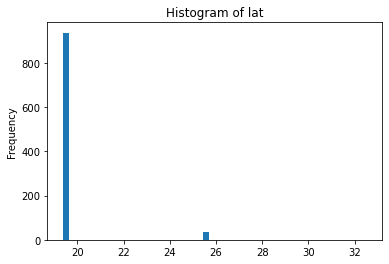

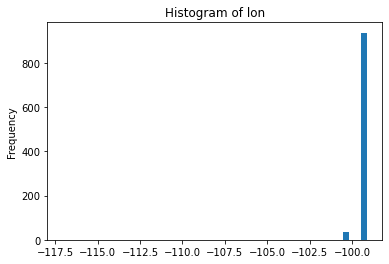

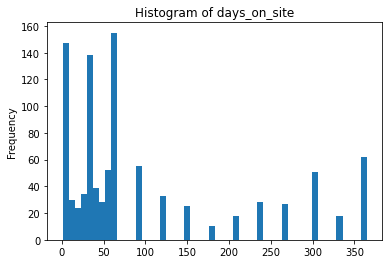

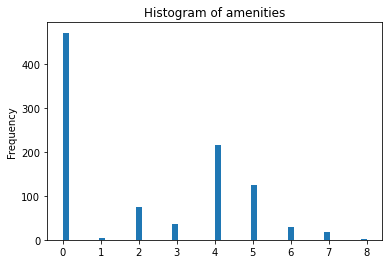

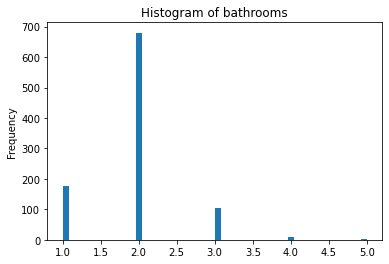

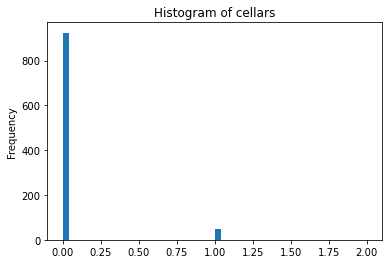

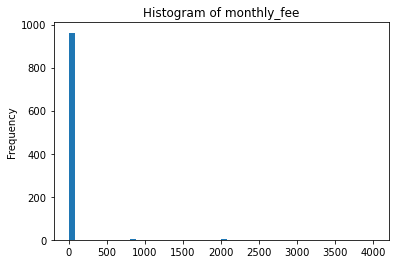

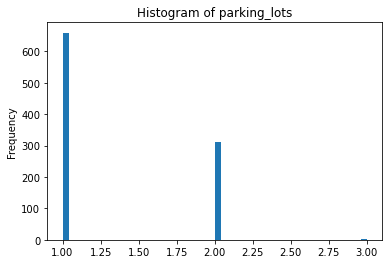

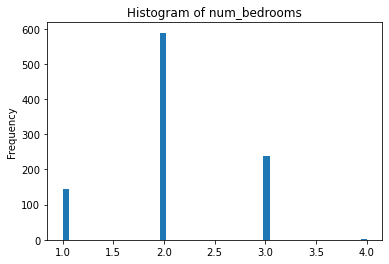

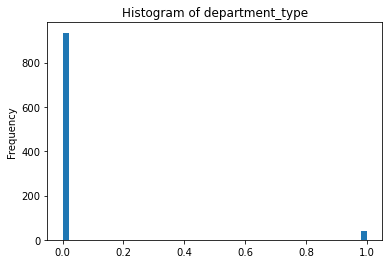

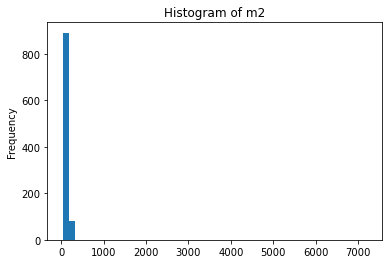

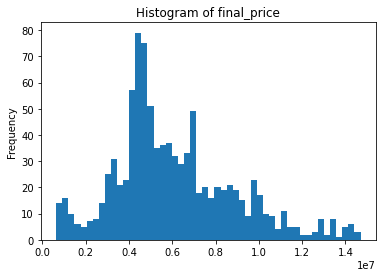

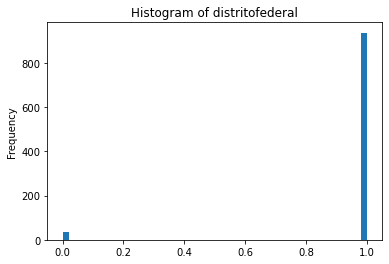

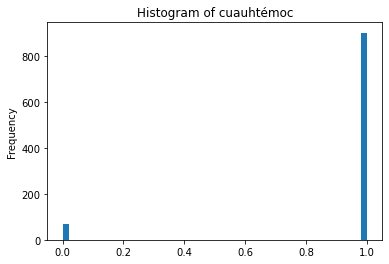

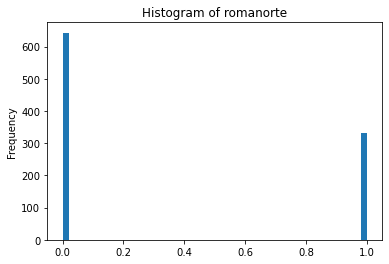

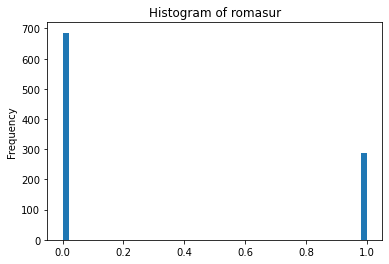

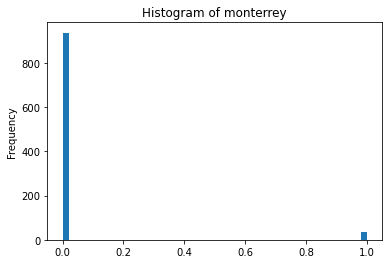

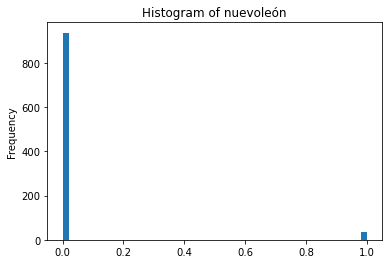

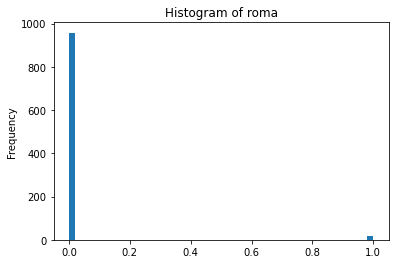

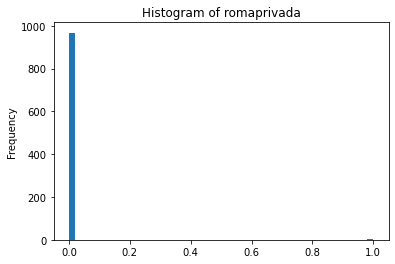

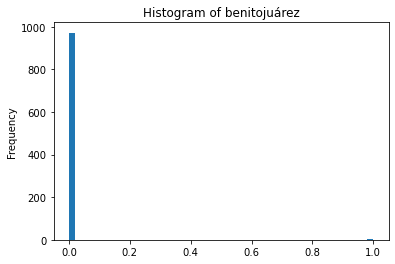

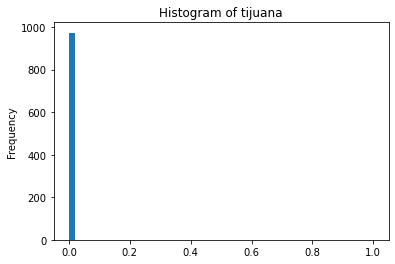

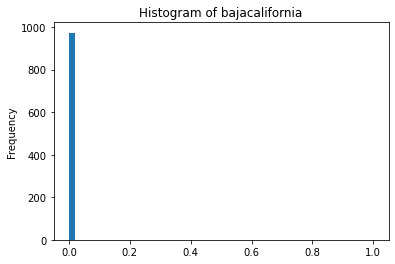

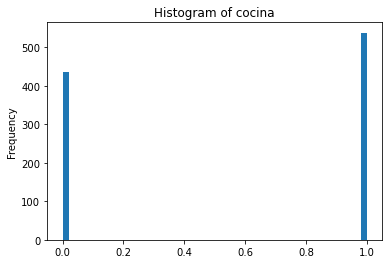

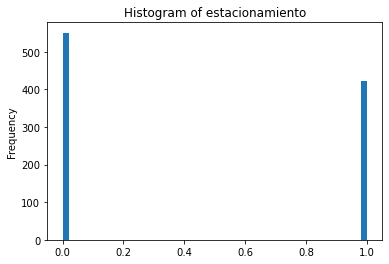

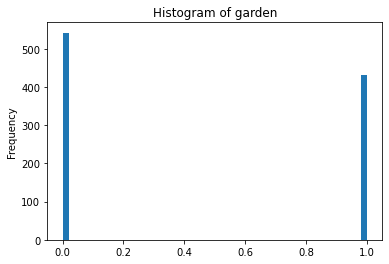

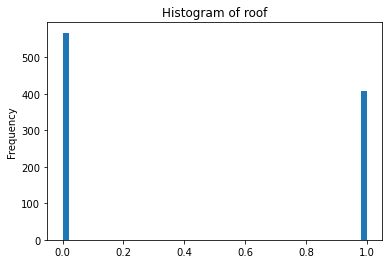

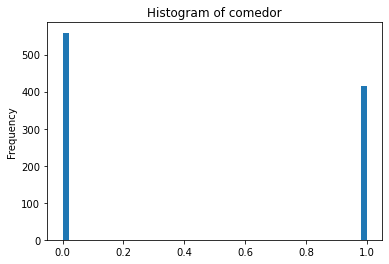

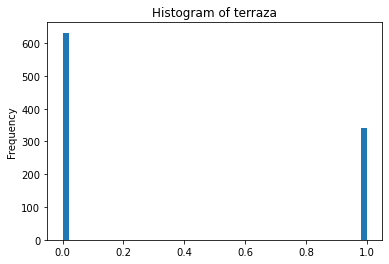

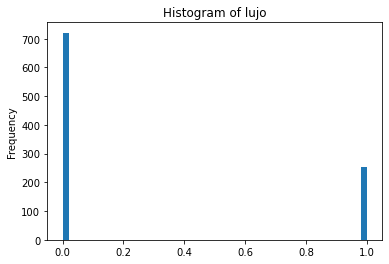

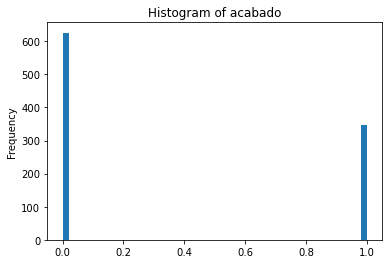

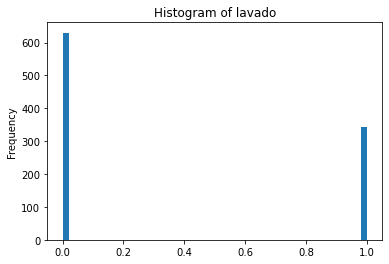

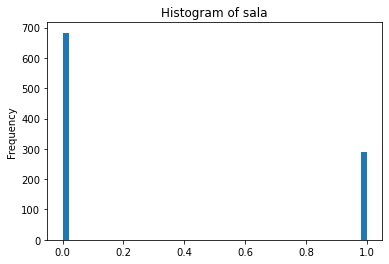

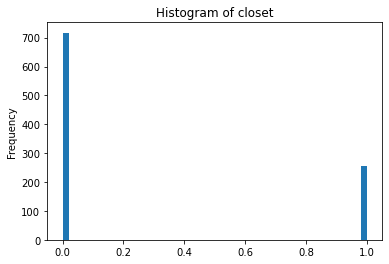

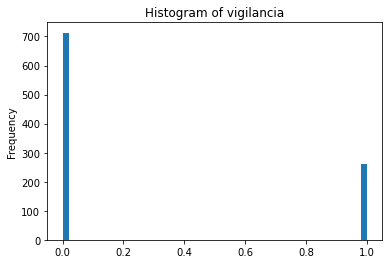

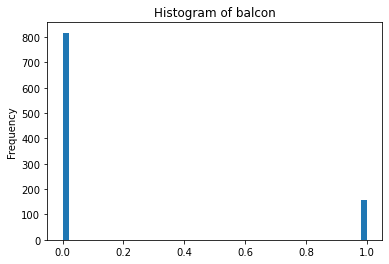

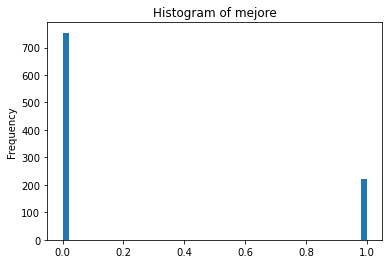

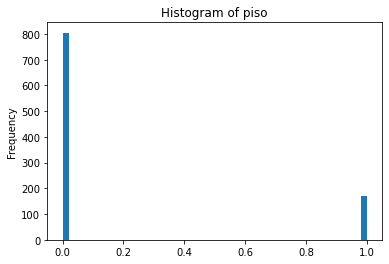

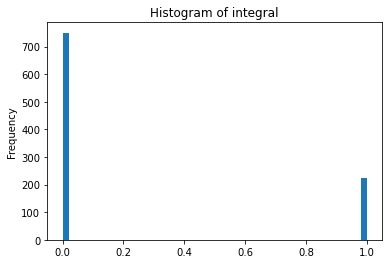

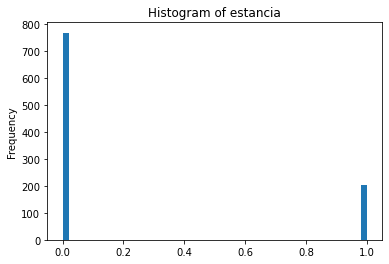

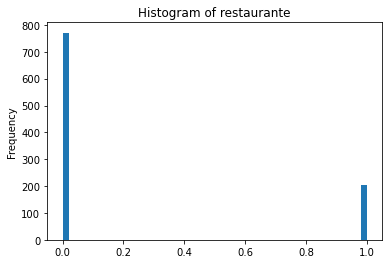

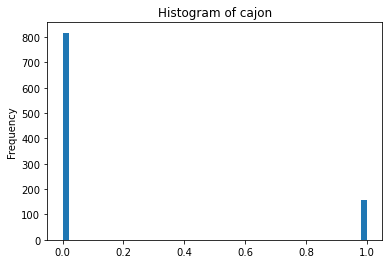

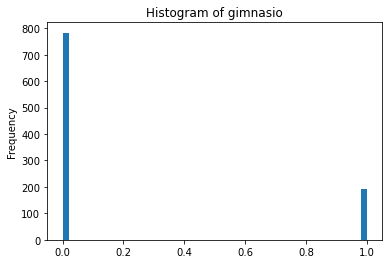

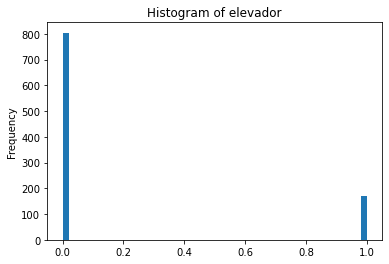

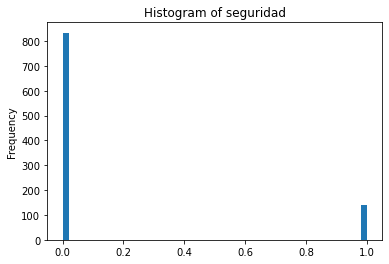

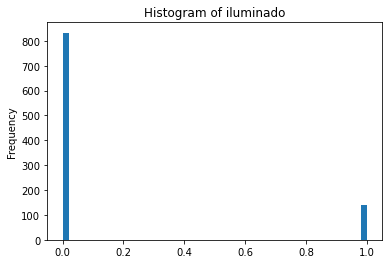

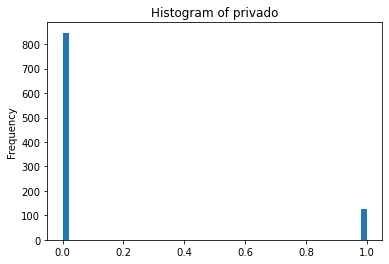

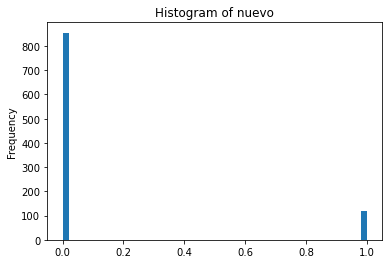

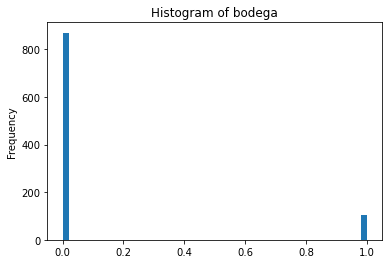

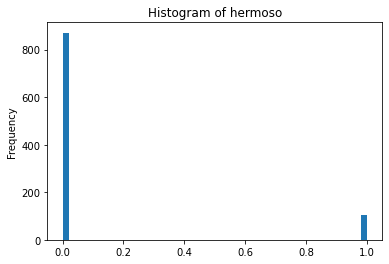

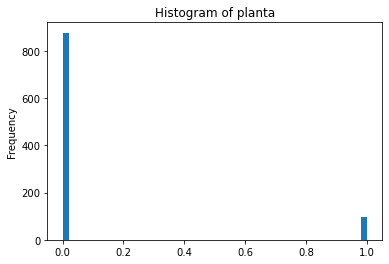

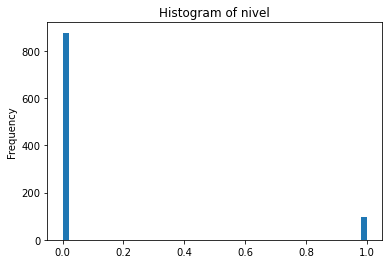

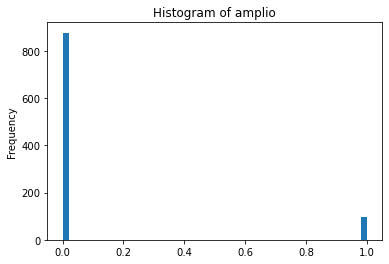

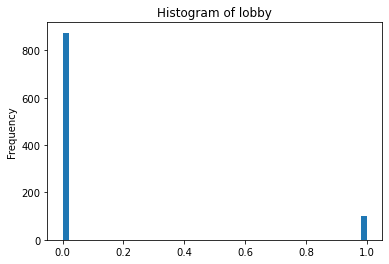

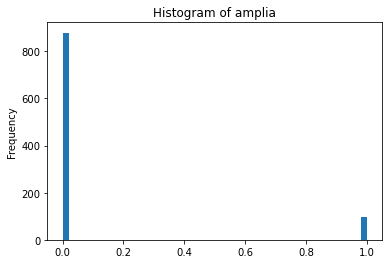

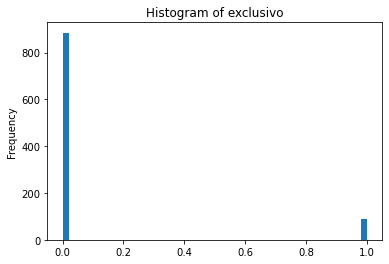

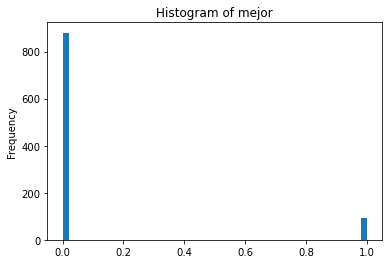

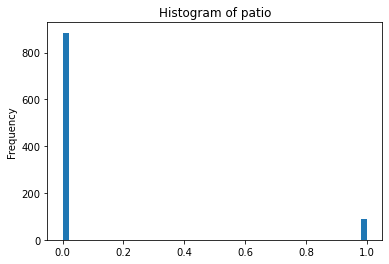

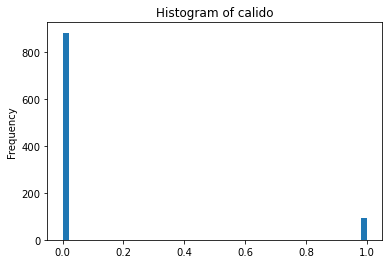

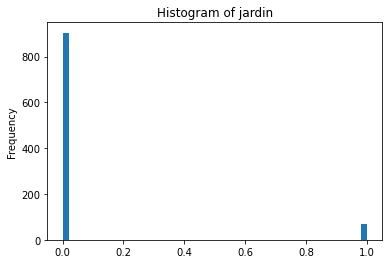

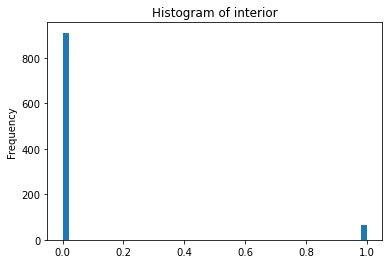

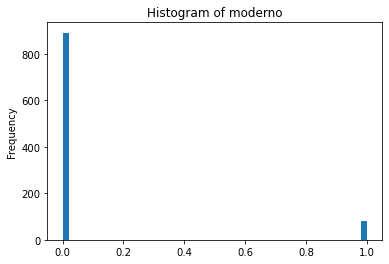

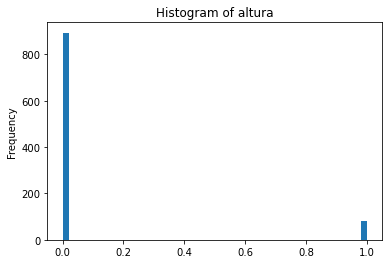

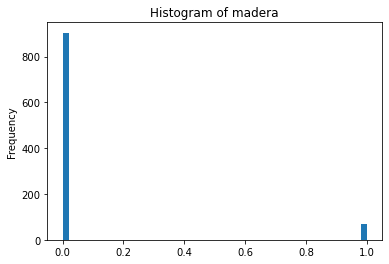

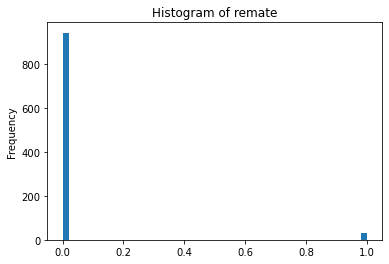

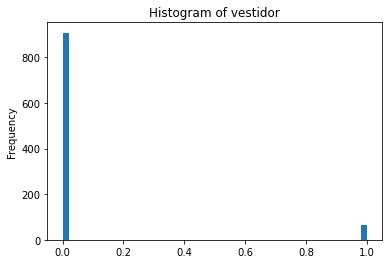

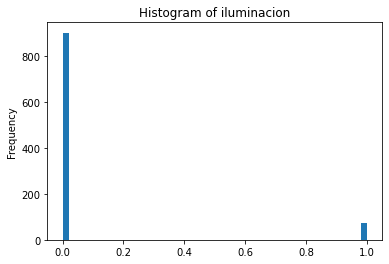

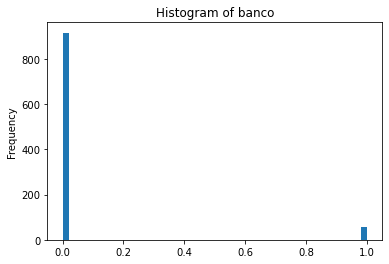

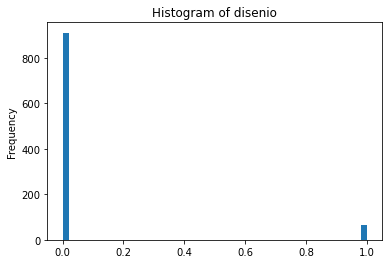

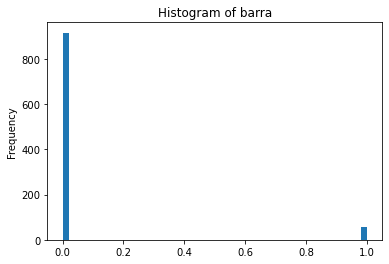

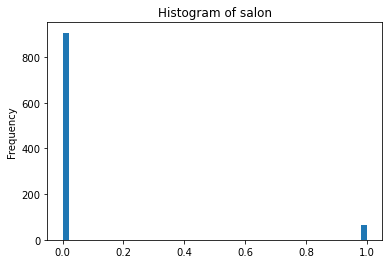

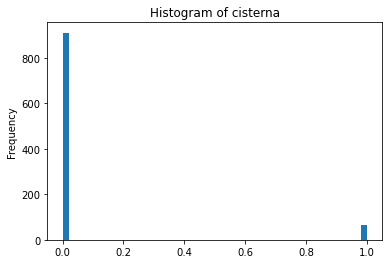

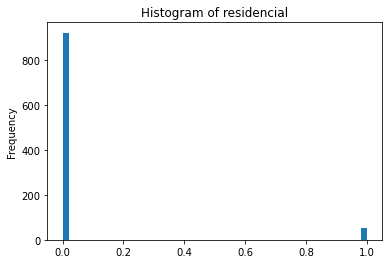

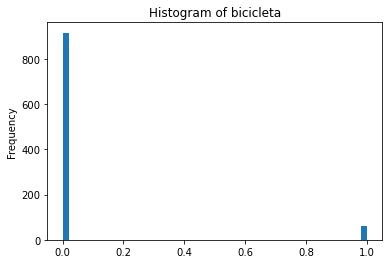

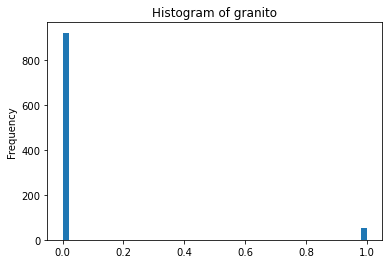

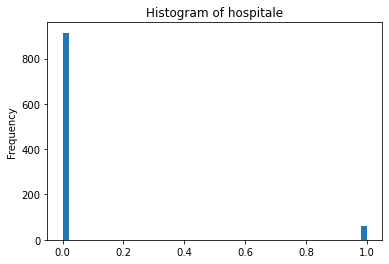

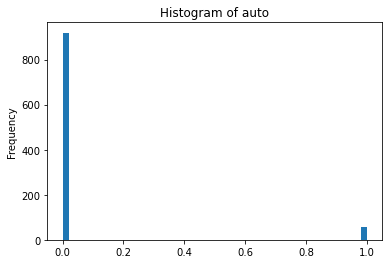

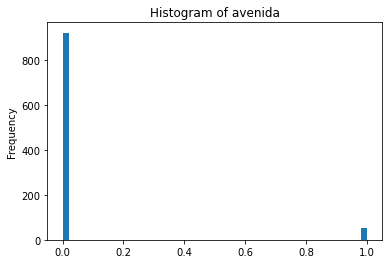

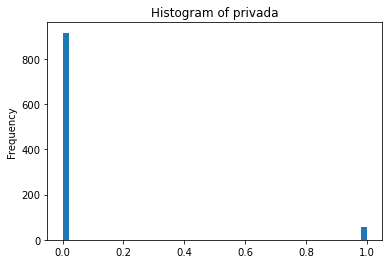

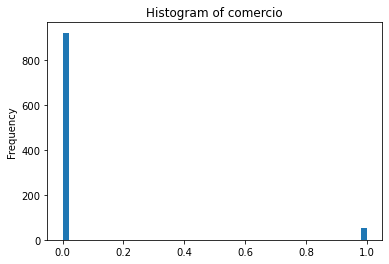

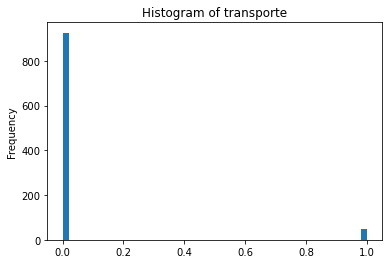

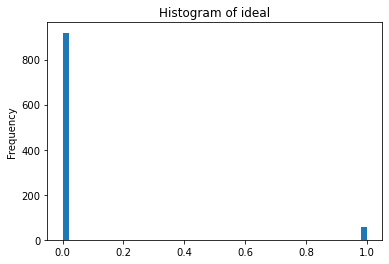

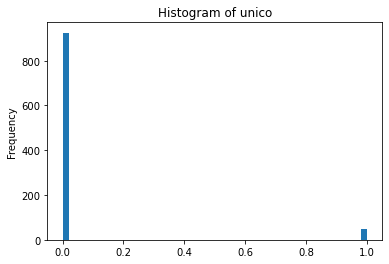

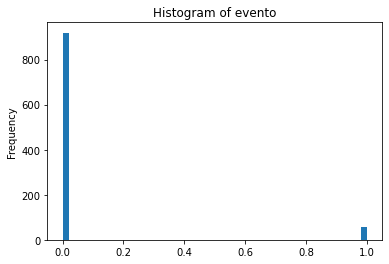

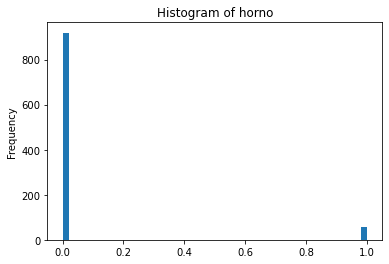

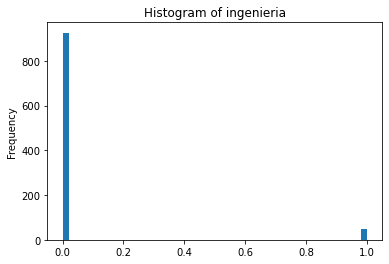

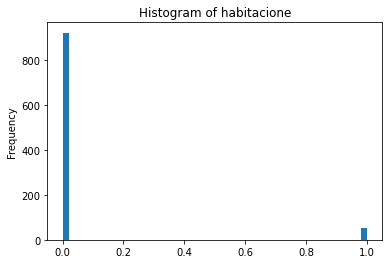

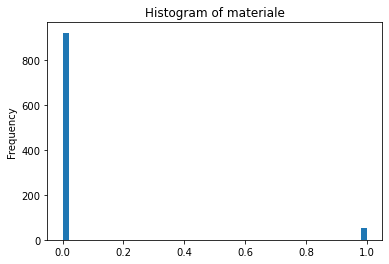

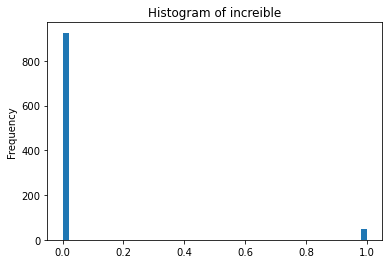

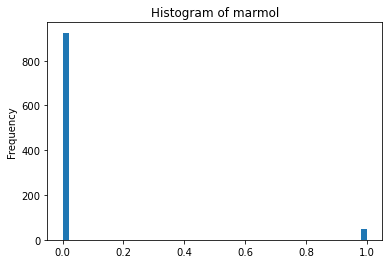

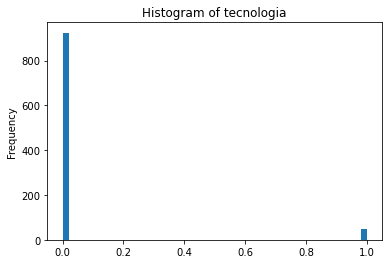

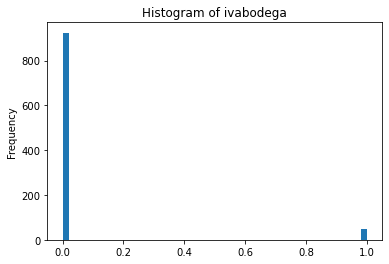

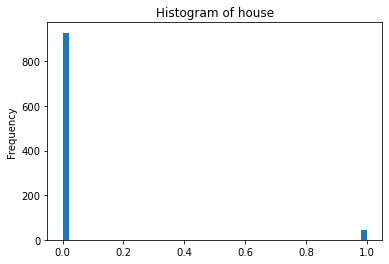

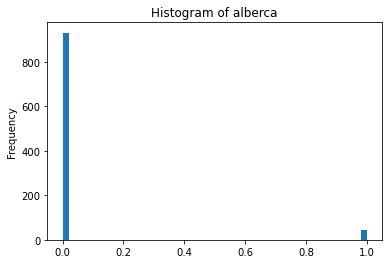

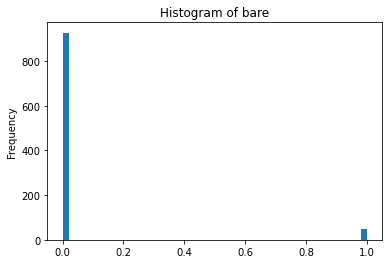

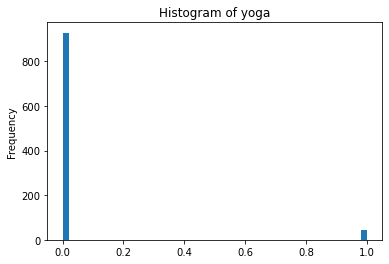

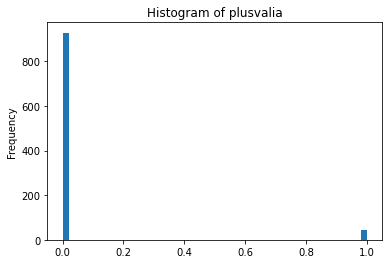

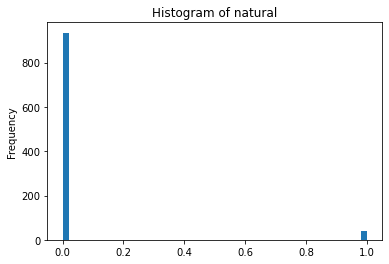

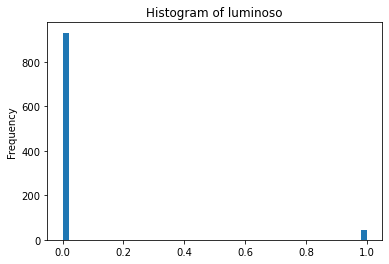

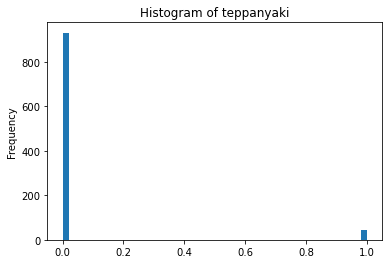

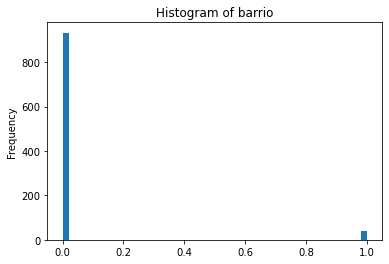

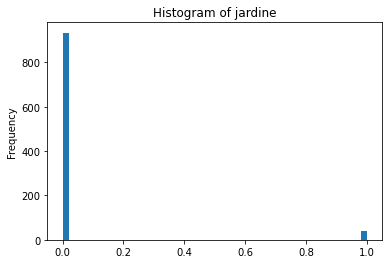

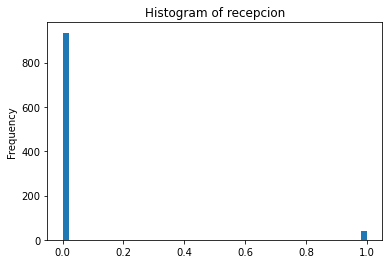

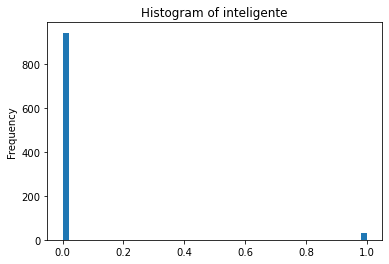

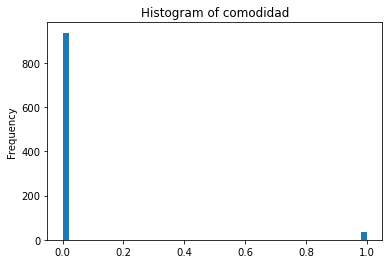

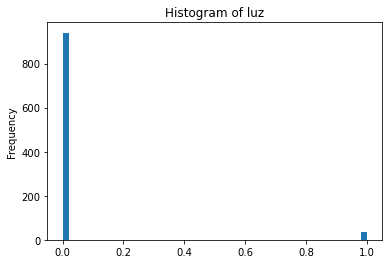

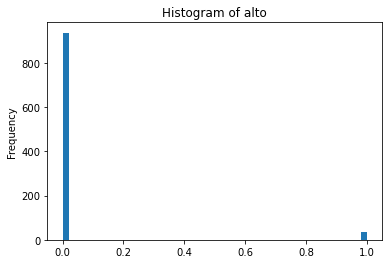

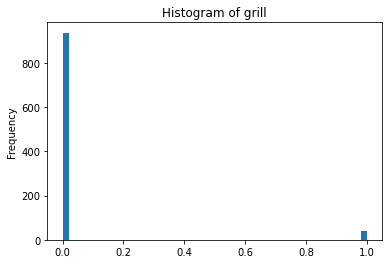

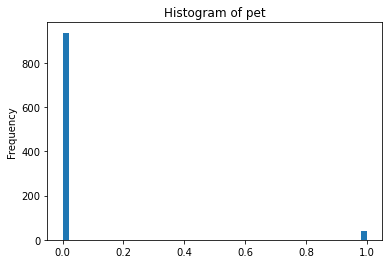

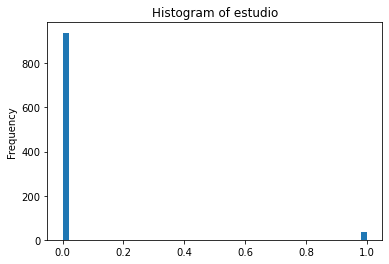

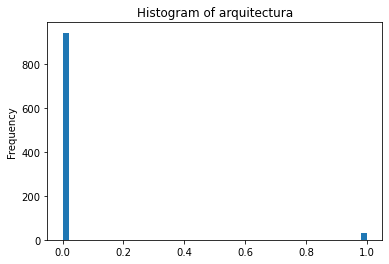

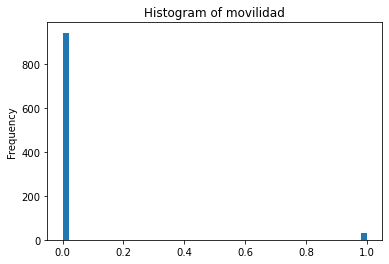

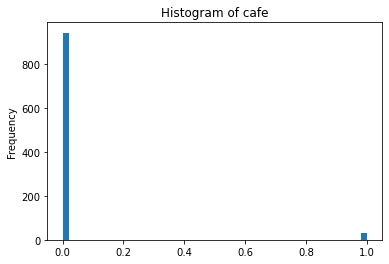

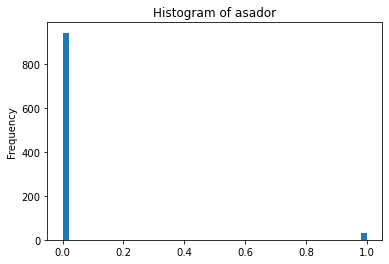

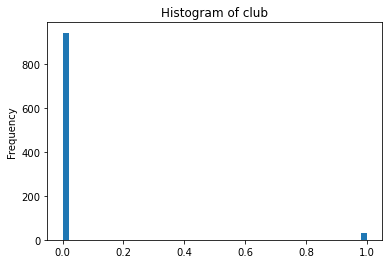

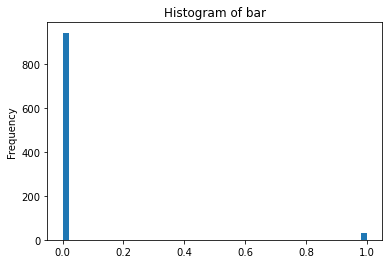

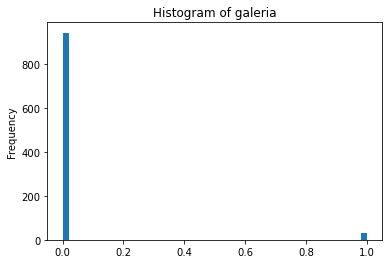

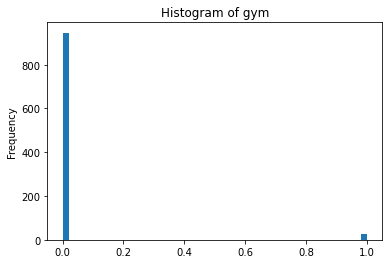

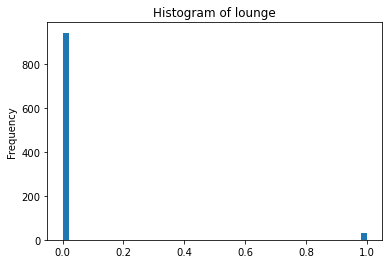

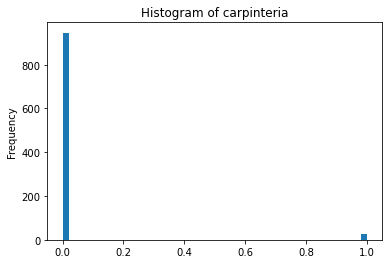

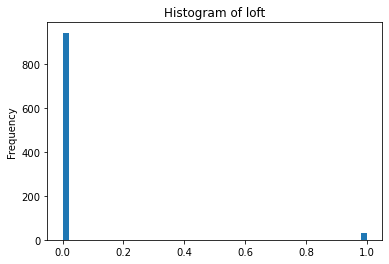

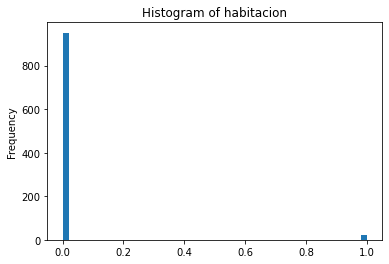

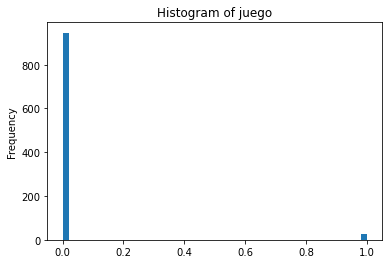

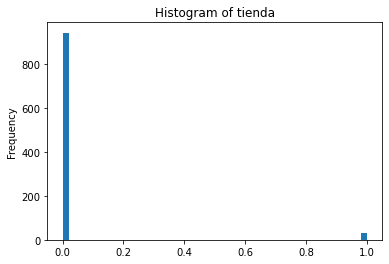

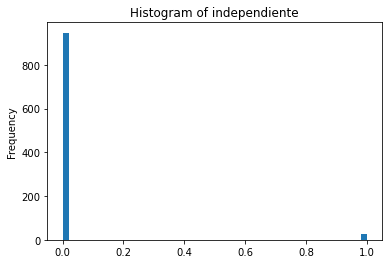

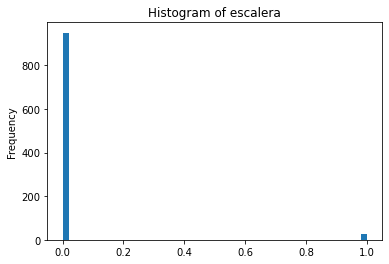

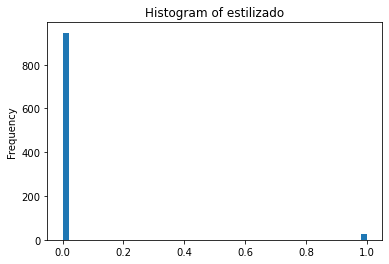

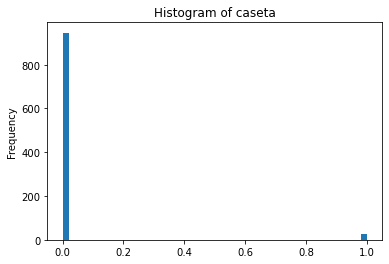

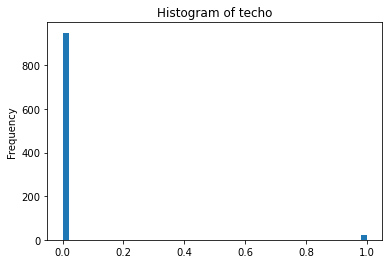

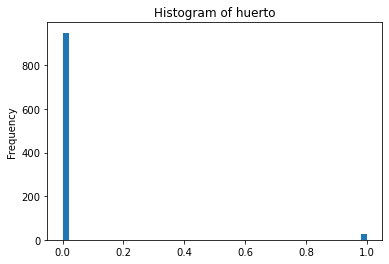

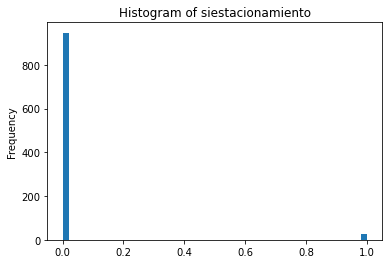

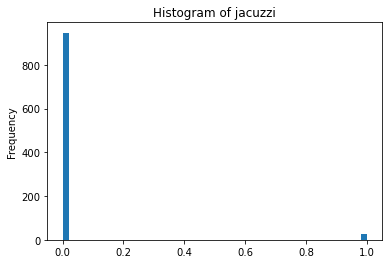

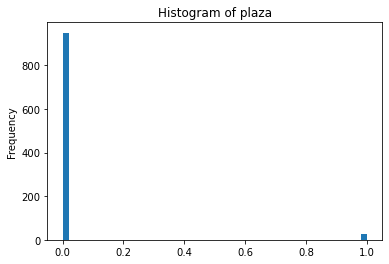

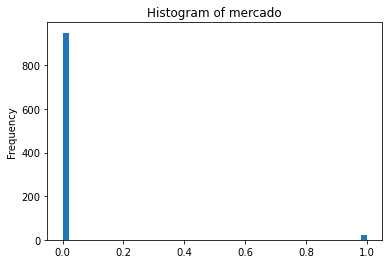

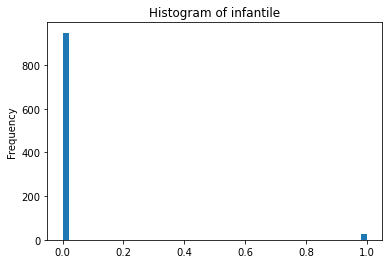

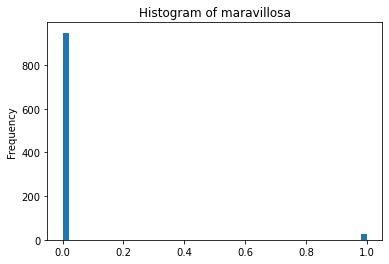

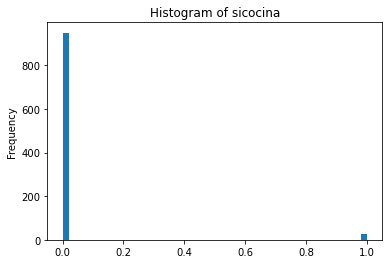

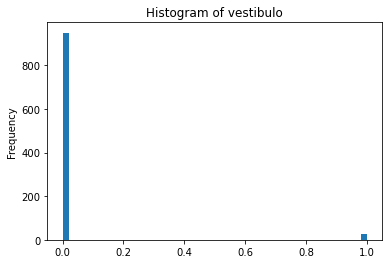

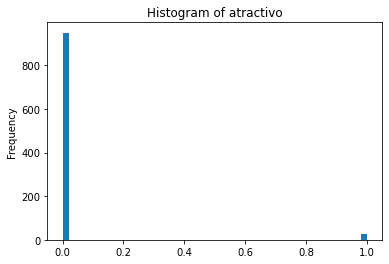

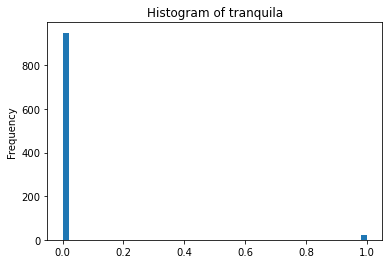

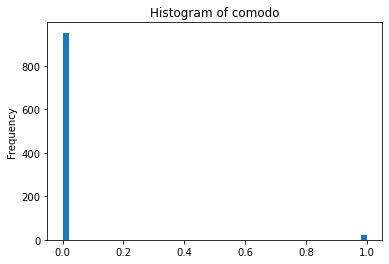

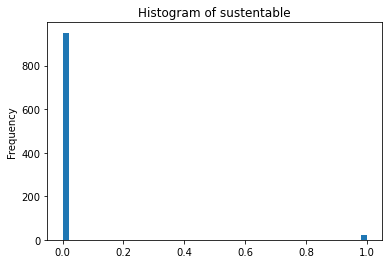

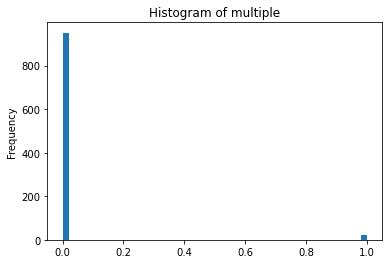

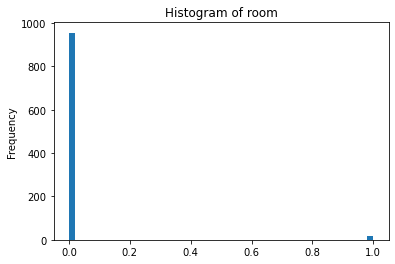

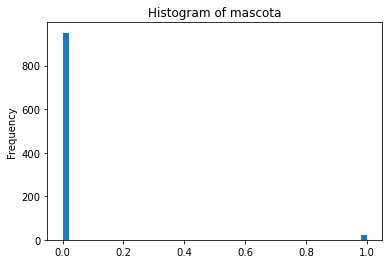

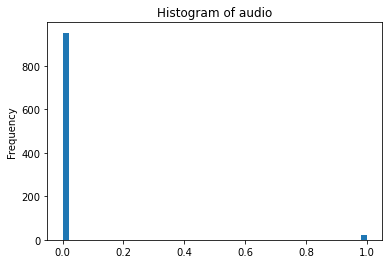

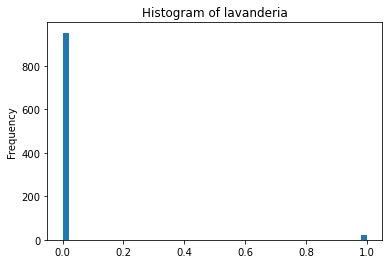

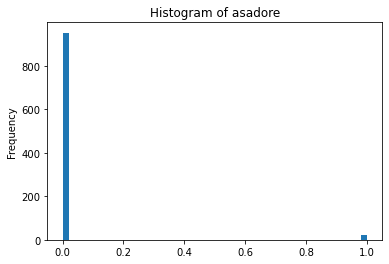

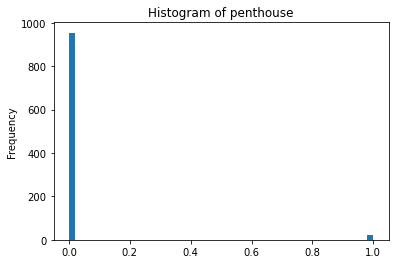

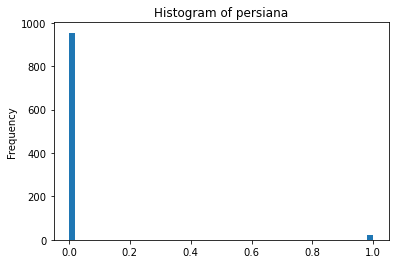

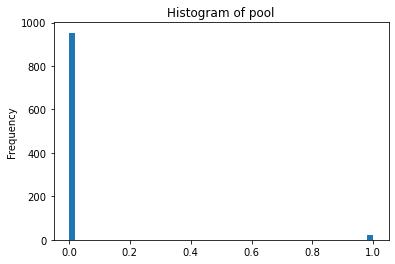

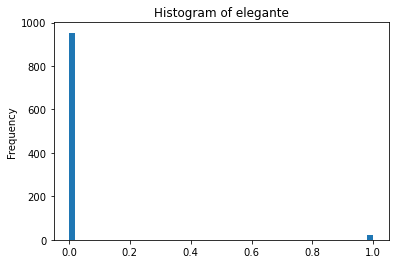

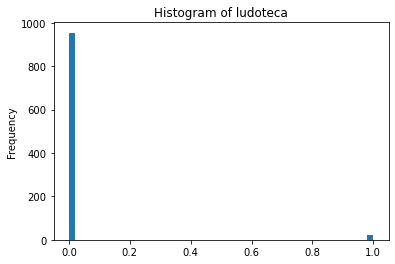

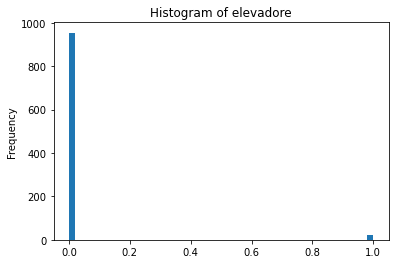

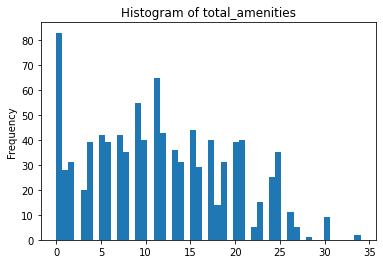

In [20]:
for i in data_final.columns:
    data_final[i].plot.hist(bins=50)
    plt.title("Histogram of "+i)
    plt.show()

In [21]:
data_final.shape[0]/data_2.shape[0]

0.9928644240570846

Al final estamos trabajando con el 99.2864% del total de registros.

## Ajustamos un modelo predictivo

Antes de ajustar el modelo, es importante mencionar observar que:

$$PriceSquareMeter=\frac{FinalPrice}{m^2} $$

de donde, $m^2$ es un valor cierto, fijo e inamovible, es decir, es una característica intrínseca del inmueble. Mientras que $FinalPrice$ es un valor variable que depende de otros factores. Por tanto, para determinar las variales que influyen en el precio por metro cuadrado, es suficiente encontrar las variables que influyen en el precio final, pues como se mencionó antes, los $m^2$ son una propiedad inata de cada inmueble.

Por tanto, el modelo se ajustará a la variable *final_price* y no a la variable *price_square_meter*

DTree... Finished!
KNN... Finished!
XGBoost... Finished!
Results... Done!


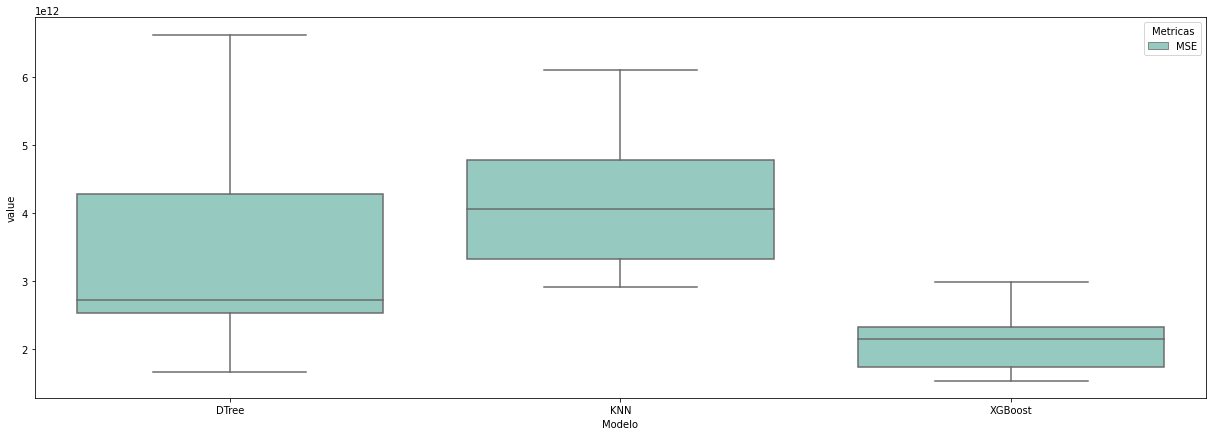

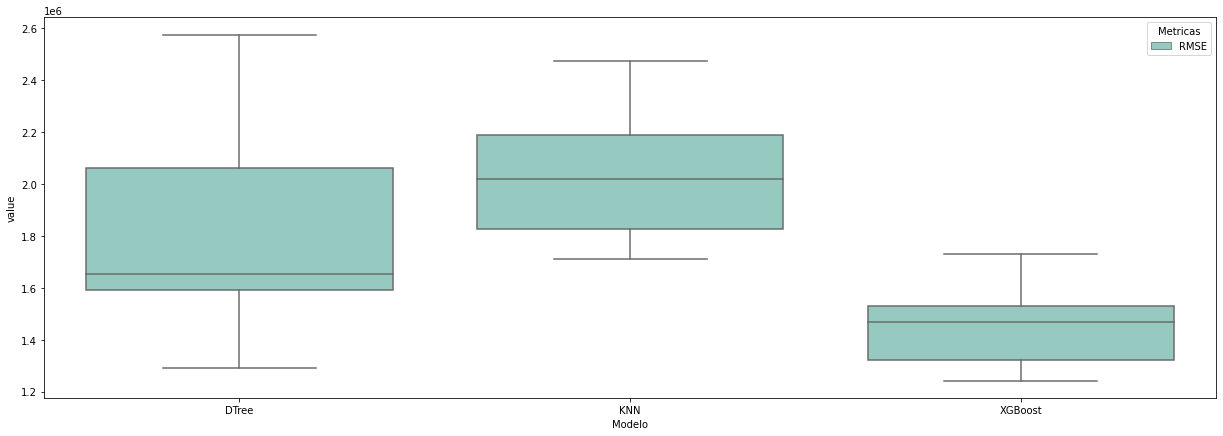

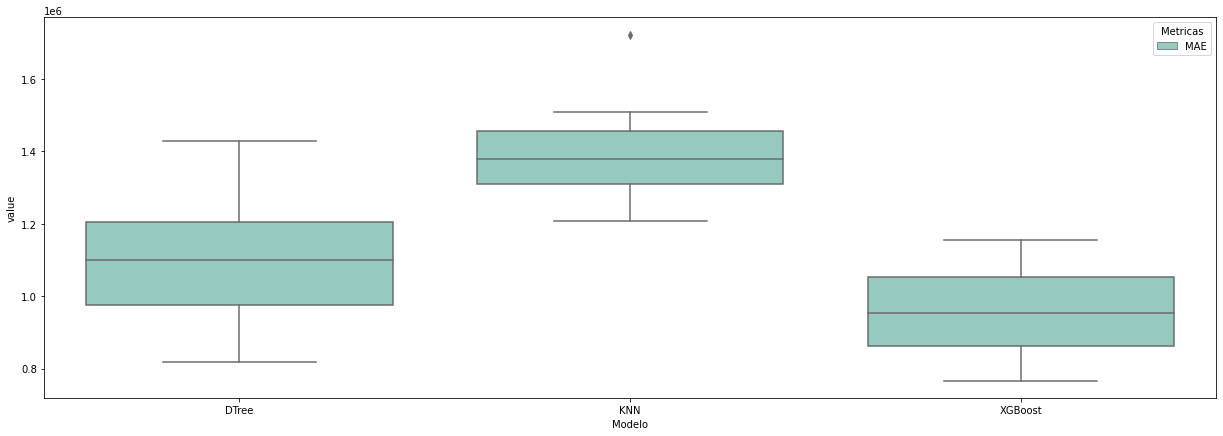

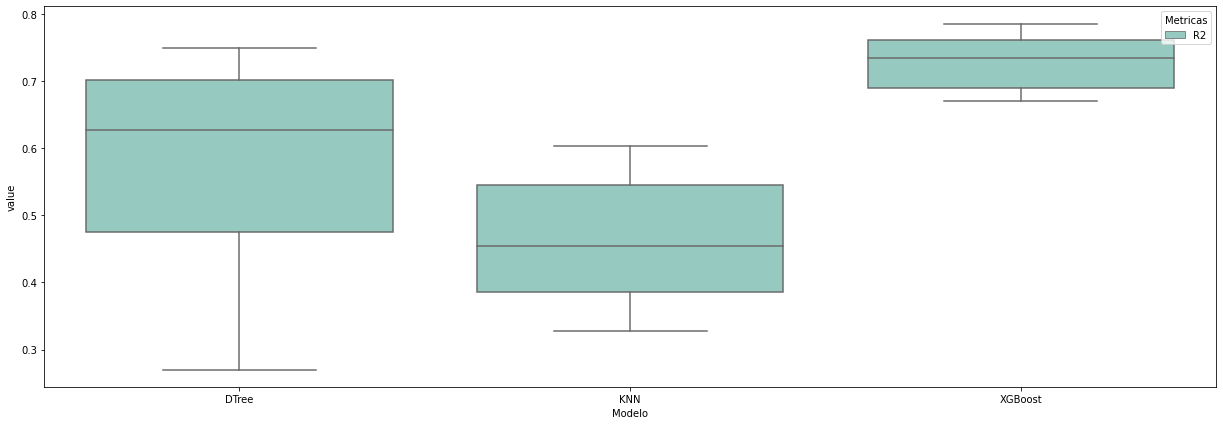

In [22]:
to_drop=[]
resultados,resumen=models(data_final,to_drop=to_drop,y="final_price",preproc=True)

In [23]:
pd.DataFrame(resumen)

,MSE_DTree,MSE_KNN,MSE_XGBoost,RMSE_DTree,RMSE_KNN,RMSE_XGBoost,MAE_DTree,MAE_KNN,MAE_XGBoost,R2_DTree,R2_KNN,R2_XGBoost
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000
mean,3.342455e+12,4.210675e+12,2.130631e+12,1.788619e+06,2.038084e+06,1.451013e+06,1.096319e+06,1.392524e+06,9.561057e+05,0.576491,0.462126,0.727799
std,1.550843e+12,1.046104e+12,4.927769e+11,3.990243e+05,2.514122e+05,1.673073e+05,1.819740e+05,1.532638e+05,1.236120e+05,0.164158,0.092228,0.041273
min,1.667319e+12,2.924329e+12,1.543815e+12,1.291247e+06,1.710067e+06,1.242503e+06,8.185377e+05,1.206290e+06,7.670005e+05,0.270315,0.327073,0.670534
25%,2.535348e+12,3.336040e+12,1.742751e+12,1.592246e+06,1.825304e+06,1.320115e+06,9.758562e+05,1.309658e+06,8.626358e+05,0.475649,0.386005,0.689859
50%,2.734060e+12,4.073188e+12,2.159311e+12,1.653356e+06,2.018149e+06,1.468981e+06,1.100242e+06,1.379360e+06,9.523219e+05,0.626559,0.454361,0.734262
75%,4.288698e+12,4.786973e+12,2.337559e+12,2.061842e+06,2.187456e+06,1.528871e+06,1.204116e+06,1.456260e+06,1.053075e+06,0.701720,0.545098,0.761688
max,6.631090e+12,6.115301e+12,2.994060e+12,2.575090e+06,2.472914e+06,1.730335e+06,1.427759e+06,1.722314e+06,1.154589e+06,0.749748,0.603334,0.785557


En general, podemos observar que el modelo que tiene un mejor performance es el XGBoost, por tanto escogemos este último como modelo vencedor.

In [24]:
y="final_price"
data_mdl1=data_final.drop(to_drop,axis=1)
Y=data_mdl1[y].to_numpy()
aux=set(data_mdl1.columns)
aux.remove(y)
features=sorted(list(aux))
X=data_mdl1[features].to_numpy()
scaler=StandardScaler()
scaler.fit(X)
mdl_bmk=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                     learning_rate = 0.1,max_depth = 10, alpha = 10, n_estimators = 25).fit(scaler.transform(X), Y)

print("this model has the following metrics:")
print("RSME:",np.sqrt(mean_squared_error(mdl_bmk.predict(scaler.transform(X)),Y)))
print("MAE:",mean_absolute_error(mdl_bmk.predict(scaler.transform(X)),Y))
print("R2:",mdl_bmk.score(scaler.transform(X),Y))

this model has the following metrics:
RSME: 940824.4923927538
MAE: 621600.8530544147
R2: 0.887630631260297


## Características determinantes

Por último, con ayuda de la *feature_importances_* del modelo, regresamos las 10 variables más relvantes 

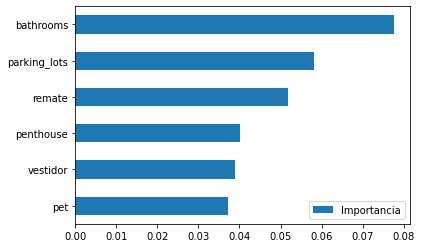

In [25]:
d={}
for i in mdl_bmk.feature_importances_.argsort()[-6:]:
    d[features[i]]=mdl_bmk.feature_importances_[i]
pd.DataFrame(d,index=["Importancia"]).T.plot.barh()
plt.show()

## Conclusiones

Con los resultados anteiores podemos decir que las variables que más influyen en el precio de un departamento (y por tanto, el valor por metro cuadrado) son:

1. el número de baños
2. el número de lugares de estacionamiento.
3. si el inmueble es remate bancario.
4. si en un departamento tipo penthhouse.
5. si tiene vestidor.
6. si es pet friendly.

Es importante mencionar que el conjunto de datos pertenece principalmente a la CDMX, específicamente a la alcaldía Cuahtémoc para las colonias Roma Norte y Roma Sur. Los siguientes pasos pueden consistir en realizar una segmentación por colonía, alcaldia, municipio o ciudad para mejorar el performance del modelo y así identificar las variables que afectan el precio por cada segmento. Así mismo, se podrían incorporar mas variables adicionales como: áreas verdes, en qué piso se encuentra el departamento y más detalles de amenidades.